In [152]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np

In [153]:
template_dir = 'templates'
templates = {}

for template_file in os.listdir(template_dir):
    if template_file.endswith('.jpg'):
        template_name = template_file.split('.')[0]
        template_path = os.path.join(template_dir, template_file)
        templates[template_name] = cv2.imread(template_path)

def match_template(card_image, template_image):
    # Convert the template to grayscale (if needed)
    template_gray = cv2.cvtColor(template_image, cv2.COLOR_BGR2GRAY)
    
    # Apply template matching
    result = cv2.matchTemplate(card_image, template_gray, cv2.TM_CCOEFF_NORMED)
    
    # Get the best match position
    _, max_val, _, max_loc = cv2.minMaxLoc(result)
    
    return round(max_val, 4), max_loc

In [154]:
def imshow(img, ax=None, cmap='gray'):
    if ax is None:
        plt.figure(figsize=(10, 10))
        ax = plt
    ax.imshow(img, cmap=cmap)
    ax.axis('off')

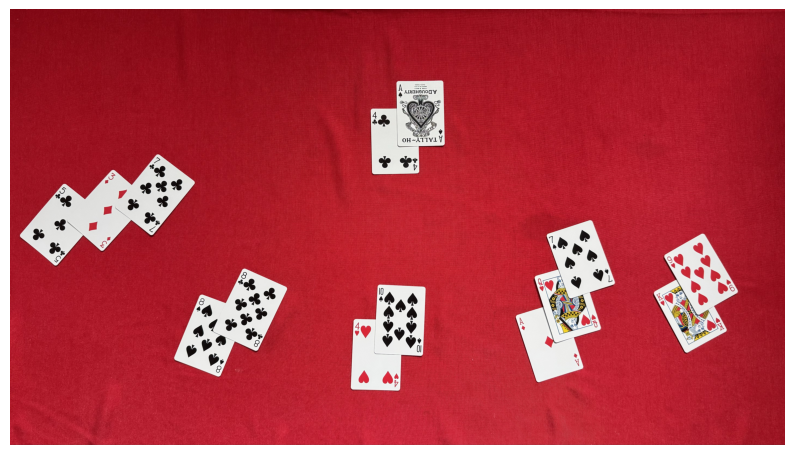

In [155]:
image_path = "database/IMG_2531.jpeg"  # Path to your uploaded image
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
imshow(image, cmap=None)

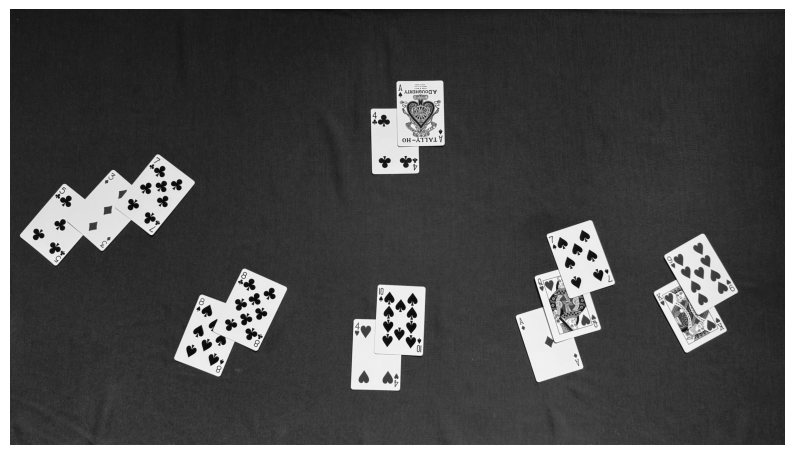

In [156]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
imshow(gray)

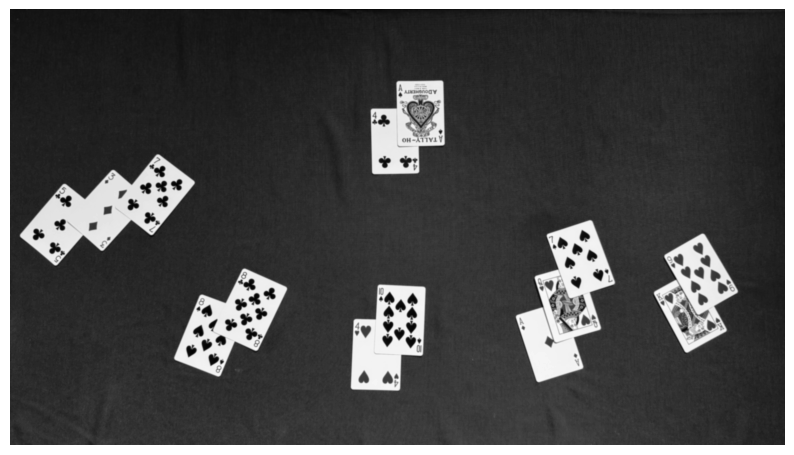

In [157]:
blur = cv2.GaussianBlur(gray, (21, 21), 0)
imshow(blur)

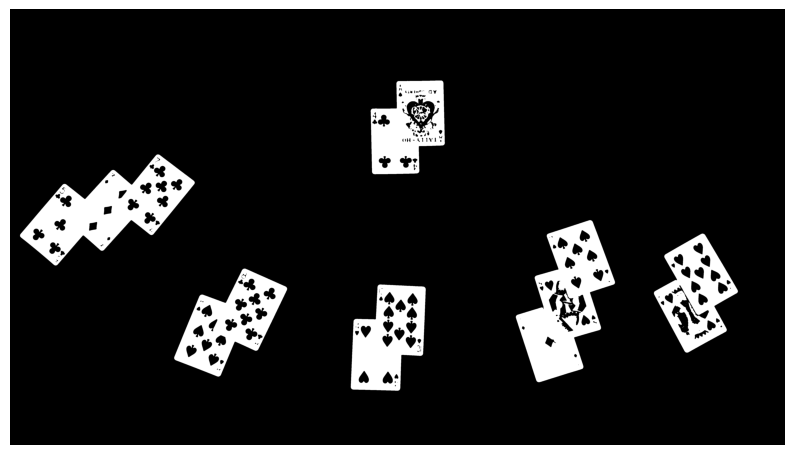

In [158]:
_, thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
imshow(thresh)

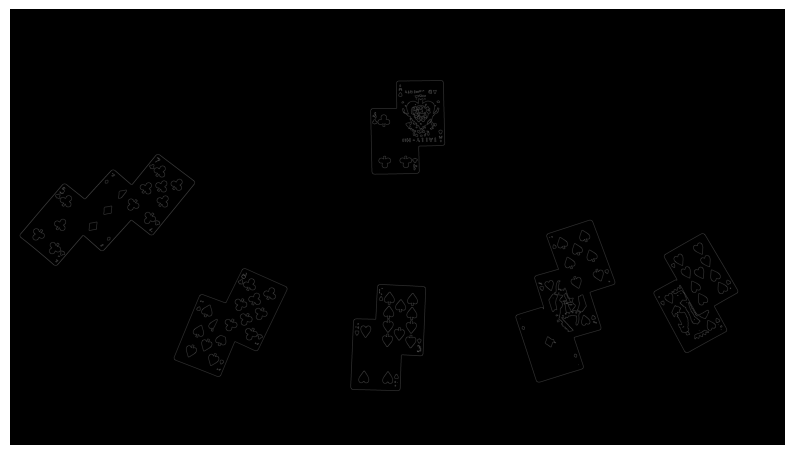

In [159]:
edges = cv2.Canny(thresh, 50, 150)
imshow(edges)

In [160]:
def flattener(image, pts, w, h):
    """Flattens an image of a card into a top-down 200x300 perspective.
    Returns the flattened, re-sized, grayed image.
    See www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/"""
    temp_rect = np.zeros((4,2), dtype = "float32")
    
    s = np.sum(pts, axis = 2)

    tl = pts[np.argmin(s)]
    br = pts[np.argmax(s)]

    diff = np.diff(pts, axis = -1)
    tr = pts[np.argmin(diff)]
    bl = pts[np.argmax(diff)]

    # Need to create an array listing points in order of
    # [top left, top right, bottom right, bottom left]
    # before doing the perspective transform

    if w <= 0.8*h: # If card is vertically oriented
        temp_rect[0] = tl
        temp_rect[1] = tr
        temp_rect[2] = br
        temp_rect[3] = bl

    if w >= 1.2*h: # If card is horizontally oriented
        temp_rect[0] = bl
        temp_rect[1] = tl
        temp_rect[2] = tr
        temp_rect[3] = br

    # If the card is 'diamond' oriented, a different algorithm
    # has to be used to identify which point is top left, top right
    # bottom left, and bottom right.
    
    if w > 0.8*h and w < 1.2*h: #If card is diamond oriented
        # If furthest left point is higher than furthest right point,
        # card is tilted to the left.
        if pts[1][0][1] <= pts[3][0][1]:
            # If card is titled to the left, approxPolyDP returns points
            # in this order: top right, top left, bottom left, bottom right
            temp_rect[0] = pts[1][0] # Top left
            temp_rect[1] = pts[0][0] # Top right
            temp_rect[2] = pts[3][0] # Bottom right
            temp_rect[3] = pts[2][0] # Bottom left

        # If furthest left point is lower than furthest right point,
        # card is tilted to the right
        if pts[1][0][1] > pts[3][0][1]:
            # If card is titled to the right, approxPolyDP returns points
            # in this order: top left, bottom left, bottom right, top right
            temp_rect[0] = pts[0][0] # Top left
            temp_rect[1] = pts[3][0] # Top right
            temp_rect[2] = pts[2][0] # Bottom right
            temp_rect[3] = pts[1][0] # Bottom left
            
        
    maxWidth = 200
    maxHeight = 300

    # Create destination array, calculate perspective transform matrix,
    # and warp card image
    dst = np.array([[0,0],[maxWidth-1,0],[maxWidth-1,maxHeight-1],[0, maxHeight-1]], np.float32)
    M = cv2.getPerspectiveTransform(temp_rect,dst)
    warp = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    warp = cv2.cvtColor(warp,cv2.COLOR_BGR2GRAY)

        

    return warp

In [161]:
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
threshold_min_area = 50_000
number_of_contours = 0

grey_pile_images = []

for c in cnts:
    area = cv2.contourArea(c)
    if area > threshold_min_area:
        cv2.drawContours(image, [c], 0, (0, 255, 0), 22)
        number_of_contours += 1
        
        peri = cv2.arcLength(c,True)
        approx = cv2.approxPolyDP(c,0.01*peri,True)
        pts = np.float32(approx)
        
        # Calculate the bounding box
        x, y, w, h = cv2.boundingRect(c)

        # Append the resized ROI
        grey_pile_images.append(flattener(image, np.float32(approx), w, h))

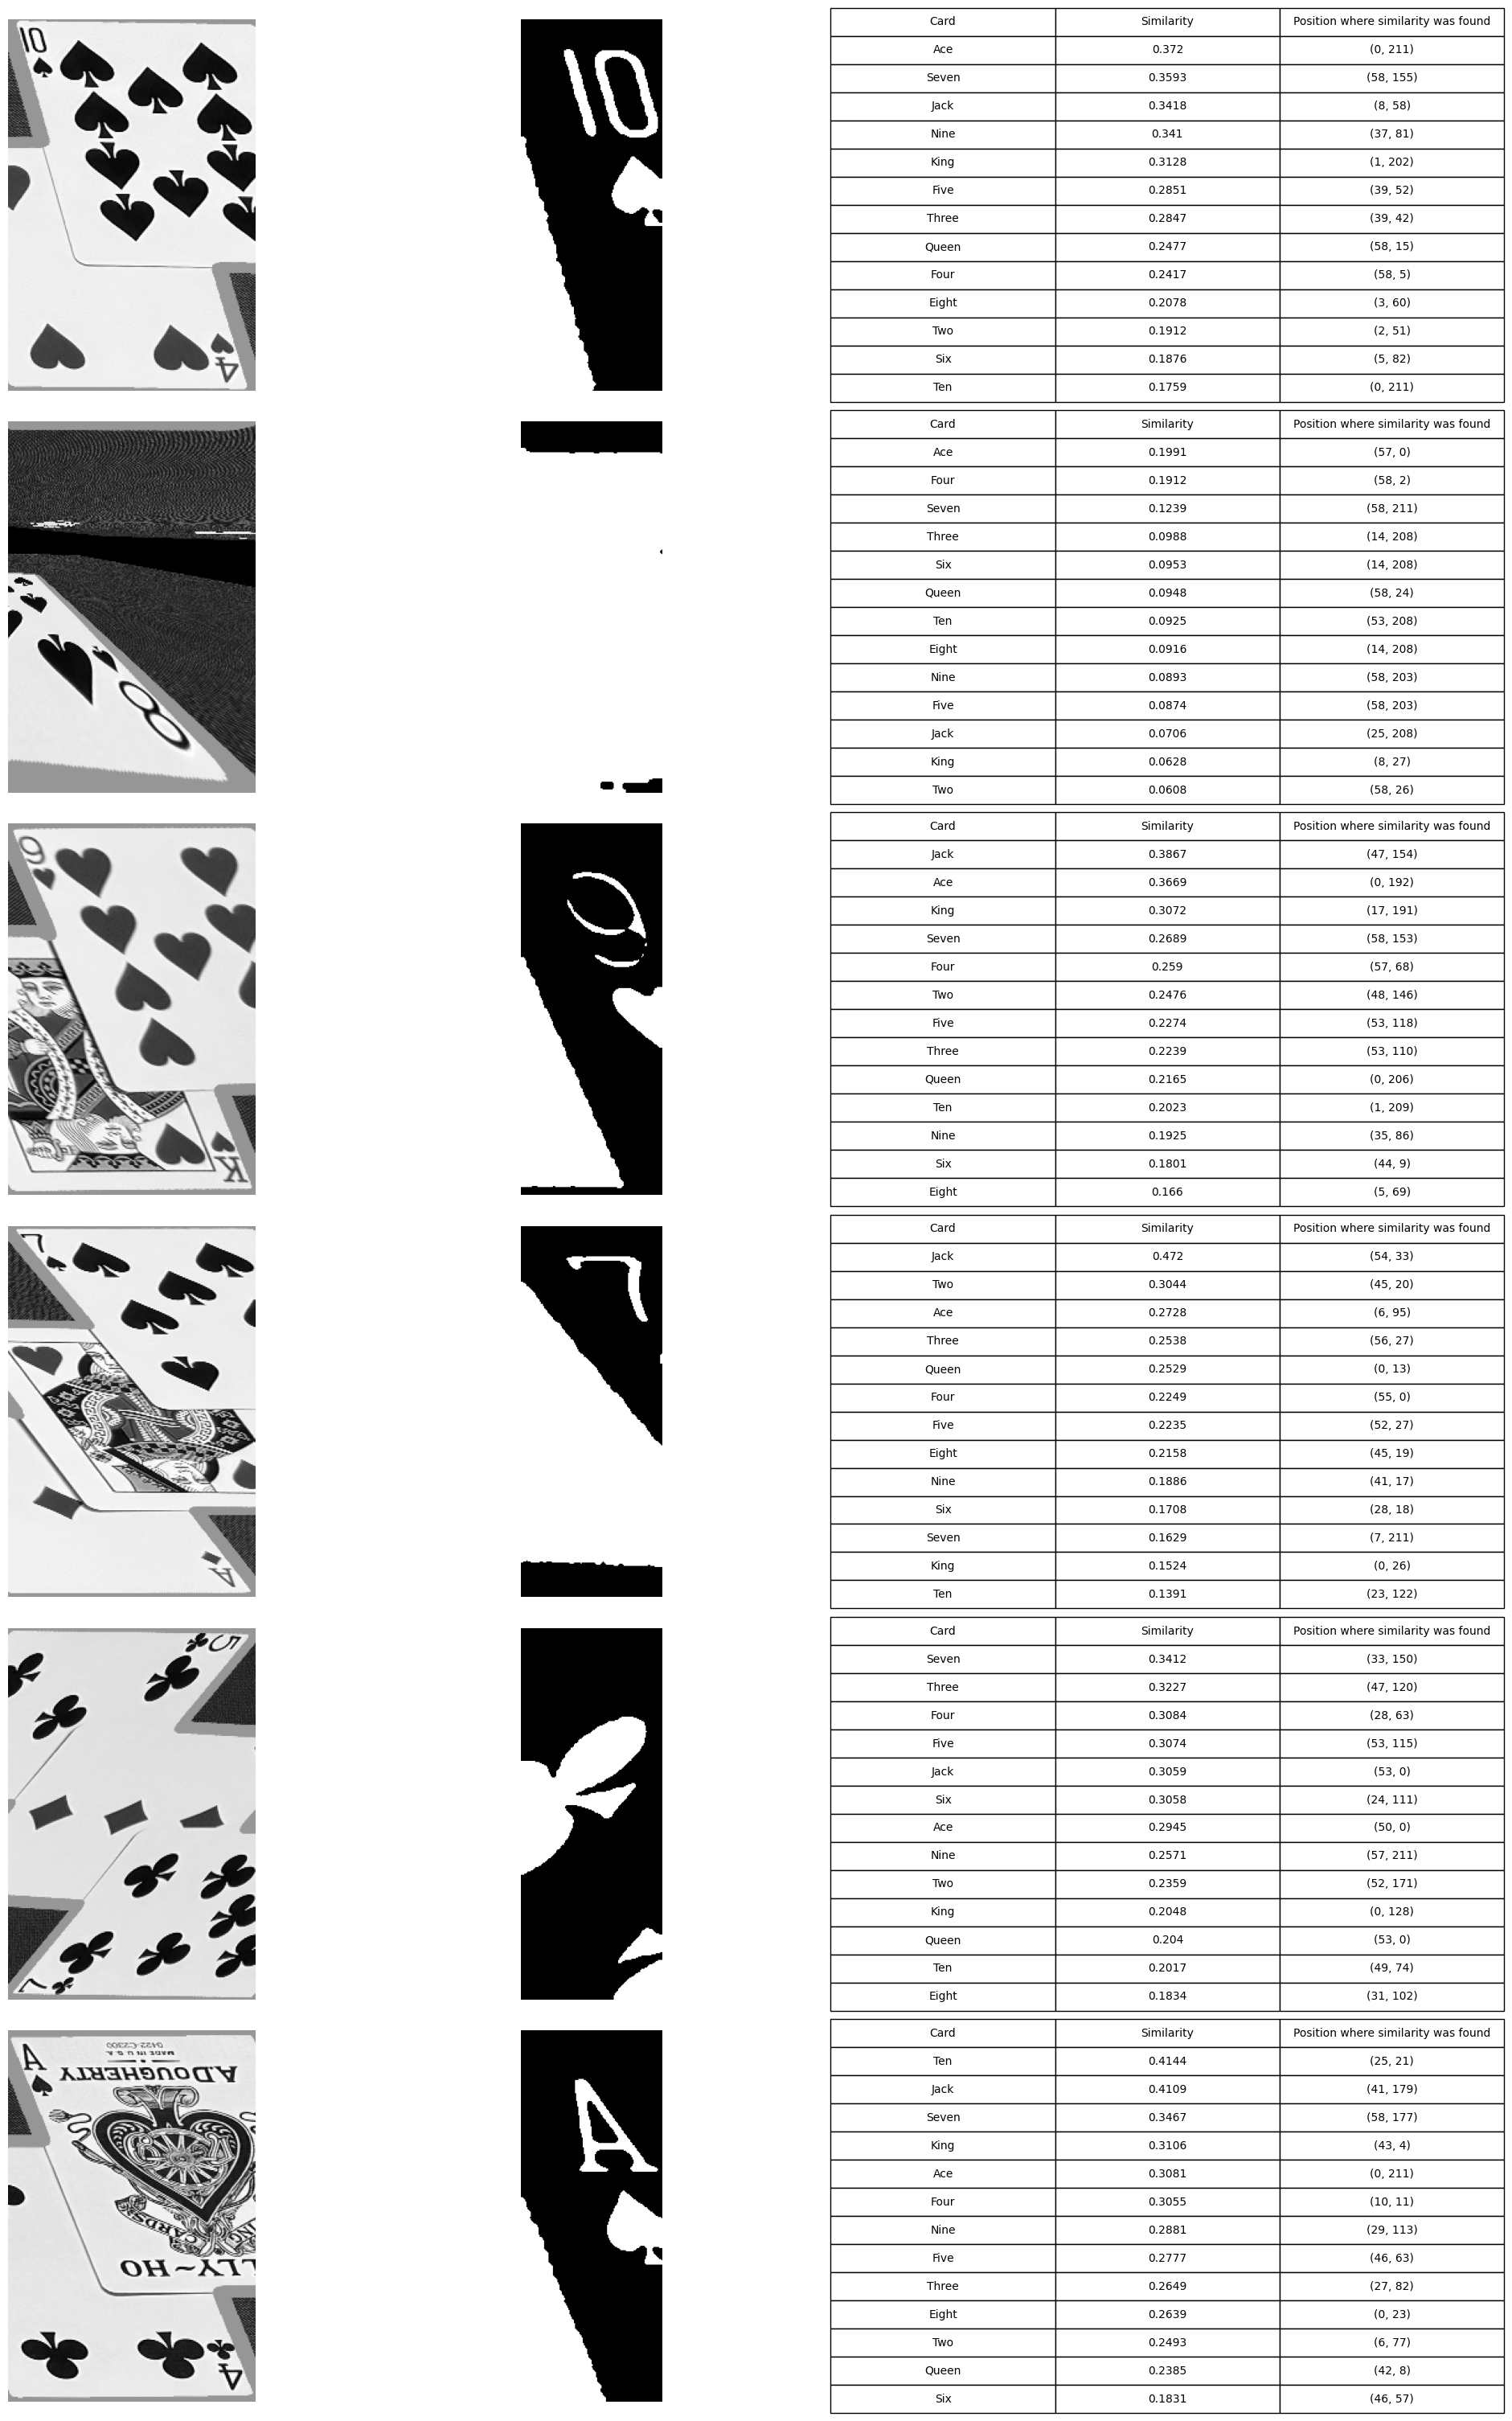

In [162]:
fig, axes = plt.subplots(len(grey_pile_images), 3, figsize=(20, len(grey_pile_images)*5), constrained_layout=True)

for i, grey_pile_image in enumerate(grey_pile_images):
    corner = grey_pile_image[0:84, 0:32]
    corner_zoom = cv2.resize(corner, (0,0), fx=4, fy=4)
    corner_blur = cv2.GaussianBlur(corner_zoom,(5,5),0)
    retval, corner_thresh = cv2.threshold(corner_blur, 155, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    axes[i, 2].axis('off')
    text = sorted([[name, *match_template(corner_thresh, template)] for name, template in templates.items()], key=lambda x: x[1], reverse=True)
    
    table = axes[i, 2].table(
        colLabels=['Card', 'Similarity', 'Position where similarity was found'],
        cellText=text,
        cellLoc='center',
        rowLoc='center',
        loc='center'
    )
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.5, 1.5)
    
    imshow(corner_thresh, axes[i, 1])
    imshow(grey_pile_image, axes[i, 0])

# Display the plot
plt.show()

Contours detected: 6


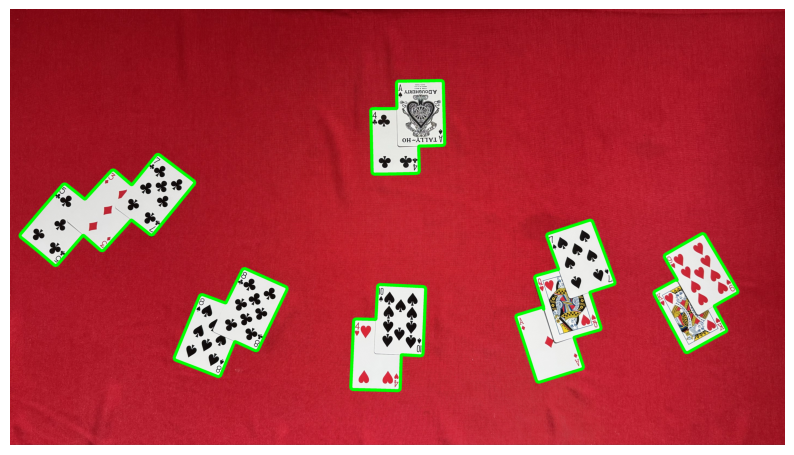

In [163]:
print("Contours detected:", number_of_contours)
imshow(image)